In [1]:
%load_ext autoreload
%autoreload 2
from imdb_code import *
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from pyvis.network import Network

In [2]:
cache = SyncMap()
cache.restore("dump.json")

In [3]:
actors = [('https://www.imdb.com/name/nm0425005/', 'Dwayne Johnson'),
          ('https://www.imdb.com/name/nm1165110/', 'Chris Hemsworth'),
          ('https://www.imdb.com/name/nm0000375/', 'Robert Downey Jr.'),
          ('https://www.imdb.com/name/nm0474774/', 'Akshay Kumar'),
          ('https://www.imdb.com/name/nm0000329/', 'Jackie Chan'),
          ('https://www.imdb.com/name/nm0177896/', 'Bradley Cooper'),
          ('https://www.imdb.com/name/nm0001191/', 'Adam Sandler'),
          ('https://www.imdb.com/name/nm0424060/', 'Scarlett Johansson'),
          ('https://www.imdb.com/name/nm0005527/', 'Sofia Vergara'),
          ('https://www.imdb.com/name/nm0262635/', 'Chris Evans')]

In [ ]:
pairs = filter(lambda x: x[0][0] != x[1][0], itertools.product(actors, repeat=2))    

df = pd.DataFrame(columns=['start', 'end', 'distance'])
with concurrent.futures.ThreadPoolExecutor(max_workers=NUMBER_OF_THREADS) as executor:
    futures = [executor.submit(get_movie_distance, cache, pair[0][0], pair[1][0], 5, 5) for pair in pairs]
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
        actor_start_url, actor_end_url, distance = future.result()
        df.loc[len(df)] = {"start": find(actors, actor_start_url), "end": find(actors, actor_end_url),
                           "distance": distance}

df.to_csv('distances.csv')

# Vizulization

In [4]:
df = pd.read_csv('distances.csv')
df

,Unnamed: 0,start,end,distance
0,0,Dwayne Johnson,Sofia Vergara,2.0
1,1,Dwayne Johnson,Akshay Kumar,2.0
2,2,Dwayne Johnson,Adam Sandler,2.0
3,3,Dwayne Johnson,Bradley Cooper,2.0
4,4,Dwayne Johnson,Chris Evans,1.0
...,...,...,...,...
85,85,Sofia Vergara,Akshay Kumar,inf
86,86,Chris Evans,Sofia Vergara,3.0
87,87,Scarlett Johansson,Akshay Kumar,inf
88,88,Robert Downey Jr.,Akshay Kumar,3.0


***Using matplotlib***

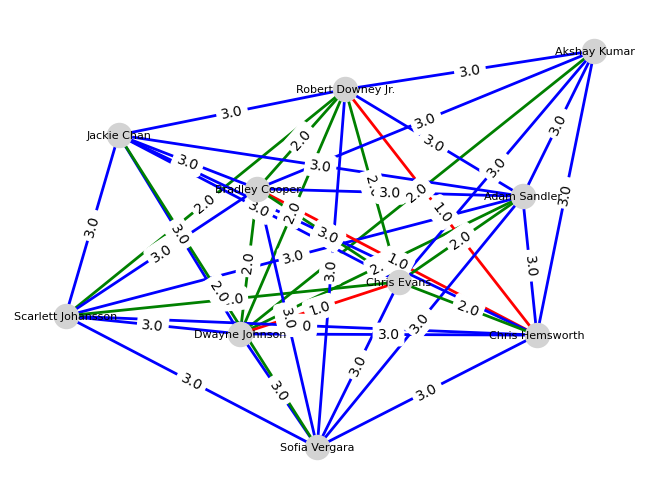

In [5]:
def plt_draw_g(df: pd.DataFrame, distance=None):
    G = nx.Graph()

    G.add_nodes_from(list(set(df['start'])))

    edges = []
    for _, row in df.iterrows():
        if row['distance'] != np.inf and (distance is None or row['distance'] == distance):
            edges.append((row['start'], row['end'], {'movie_distance': row['distance']}))
    G.add_edges_from(edges)

    edge_colors = {1: 'red', 2: 'green', 3: 'blue'}
    movie_distances = nx.get_edge_attributes(G, 'movie_distance')

    edge_colors_list = [edge_color_mapping(movie_distance, edge_colors) for _, movie_distance in movie_distances.items()]

    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightgray', edge_color=edge_colors_list, width=2, font_size=8, font_color='black')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=movie_distances)
    plt.show()

plt_draw_g(df)

***Using pyvis***

In [6]:
def pyvis_draw_g(df: pd.DataFrame, distance=None):
    G = nx.Graph()

    G.add_nodes_from(list(set(df['start'])))

    edges = []
    edge_colors = {1: 'red', 2: 'green', 3: 'blue'}
    for _, row in df.iterrows():
        if row['distance'] != np.inf and (distance is None or row['distance'] == distance):
            edges.append((row['start'], row['end'], {'movie_distance': row['distance'],
                                                     "color": edge_color_mapping(row['distance'], edge_colors),
                                                     "label": str(row['distance'])}))
    G.add_edges_from(edges)

    nt = Network(notebook=True, cdn_resources='remote', directed=True,  select_menu=True)
    nt.from_nx(G)
    nt.set_options("""
    const options = {
      "physics": {
        "barnesHut": {
          "theta": 0.7,
          "gravitationalConstant": -9350,
          "centralGravity": 1.1,
          "damping": 0.3,
          "avoidOverlap": 0.37
        },
        "minVelocity": 0.75,
        "timestep": 0.6
      }
    }
    """)
    return nt

nt = pyvis_draw_g(df)
nt.show("res.html")

# Word Cloud

In [ ]:
path = "./"
for actor_url, actor_name in tqdm(actors, total=len(actors)):
    soup = get_soup_from_driver(actor_url, 'ipc-see-more__button', 1)
    descriptions = get_movie_descriptions_by_actor_soup(soup)
    with open(path + actor_name.replace(" ", "_") + '.json', 'w') as f:
        json.dump(descriptions, f)

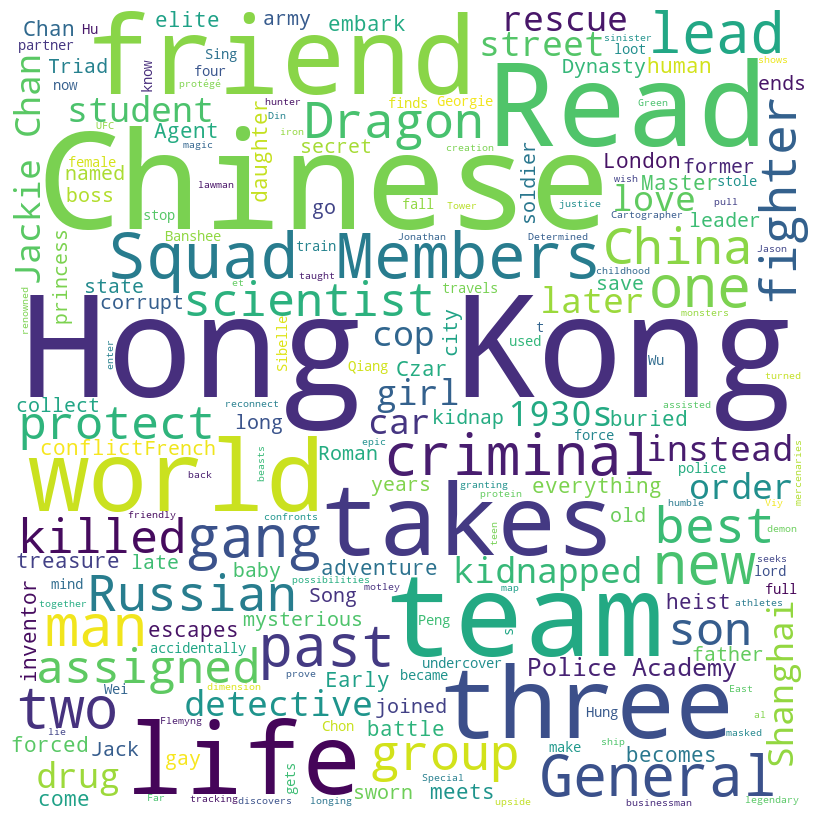

In [7]:
def draw_word_cloud(descriptions: list):
    combined_text = ' '.join(descriptions)

    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=stopwords).generate(combined_text)

    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

with open("Jackie_Chan.json", 'r') as f:
    descriptions = json.load(f)
draw_word_cloud(descriptions)